In [9]:
import glob
import pandas as pd
from array import ArrayType
import numpy as np

# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
# saveFolderName = "peak"
genSavePath = f"{os.getcwd()}/SavedResults/"

In [10]:
import paradigmSetting
day = "14" # Which month and days result you want to visualize in table
month = 12

nrOfLabels = 5


cmbSize = 3
repetitionValue = 5
# featureSelect = "myOwnTestAvg2" # 
featureSelect = "myOwnTestSadAngryHappyDisgusted"
# featureSelect = "myOwnTestUpDownLeftRight"

paradigm = paradigmSetting.sadAngryHappyDisgustedJulia()
# # featureSelect = "4UpDownLeftRight" # 
# paradigm = paradigmSetting.UpDownLeftRightJulia()
myDataset = True
# featureSelect = "myOwnTestAvgRef" #  
# featureSelect = "nietoTest" # 
# paradigm = paradigmSetting.upDownRightLeftInner()
# paradigm = paradigmSetting.upDownRightLeftInner()
# paradigm = paradigmSetting.rightLeftInner()
# featureSelect = "OnlySepOnlyCurr01thTESTHoldOut70"
resultFolder = "withDiff90thresh/"
paraName = paradigm[0]
labels = np.arange(nrOfLabels) 
saveTables = True
saveTop = True
saveHoldTop = True
saveSepTop = True
saveAvgTop = False
import matplotlib as mpl
mpl.rcParams["figure.dpi"]  = 80
diffThresh = -0.05


In [11]:
repetitionName = f"{paraName}{cmbSize}c{featureSelect}" #"debuggingOnlyCurrthreeAv2correct" #"debuggingOnlyPreNotCurrthreeAv2Correct"# "testAvgDoubleBC4labelsinner2c" # "testAvgDoubleBC4labels1c" # #"peak4-const3-i-ud-global-10-3c"  # "i-ud-global-05-2c" # # "withFixedButWorse3"# #  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")
if saveTop:
    saveTopName = f"top{cmbSize}{paraName}.npy"
else:
    saveTopName = None
if saveAvgTop:
    saveTopAvgName = f"topAvg{cmbSize}{paraName}.npy"
else:
    saveTopAvgName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.0
print(len(savedResults))
print(len(savedResults)/9)

63
7.0


In [14]:
# All results table
nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    for featCombo in subinfo[1]:
        if featCombo not in featCombos:
            featCombos.append(featCombo)

allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1

timesPerCombo = np.zeros([comboNumber])
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
combinationResultSep = np.zeros([subjectAmount, len(allCombinations), nrOfLabels+2])
hcombinationResultSep = np.zeros([subjectAmount, len(allCombinations), nrOfLabels+2])

combinationAmounts = np.zeros([subjectAmount, len(allCombinations)])
combinationDiffs = np.zeros([subjectAmount, len(allCombinations),nrOfLabels])
nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), 20])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)
    
    currSubj = subject[1]

    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            # print(type(aResults2))
            # print(aResults2)
            
            if len(aResults2) < 10:
                aName = aResults2[0]
                ares = aResults2[1][0]
                sepRes = aResults2[1]
                # print(sepRes)
                # print(ares)
                akernel = aResults2[2]
                aC = aResults2[3]
                diff = aResults2[5]
                # print(sepRes)
                # print(ares)
                
                if ares > 0.99:
                    ares = 0.99
                ares = round(ares,2)
                hsepRes = aResults2[4]
                # print(hsepRes)
                for i, r in enumerate(hsepRes):
                    if r > 0.99:
                        hsepRes[i] = 0.99
                        # print("AAAAAAA")
                    hsepRes[i] = round(hsepRes[i],2)
                for i, r in enumerate(sepRes):
                    if r > 0.99:
                        sepRes[i] = 0.99
                    sepRes[i] = round(sepRes[i],2)
                        # print("AAAAAAA")
                timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]] = timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]]  + 1
                if combinationDict.get(f"{aName},{akernel},{aC}") is not None:
                    combinationDiffs[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] += diff
                    combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
                    for ind, seperRes in enumerate(sepRes[1:]):
                        combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][0] = int(combinationDict[f"{aName},{akernel},{aC}"])
                        combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][ind+1] += seperRes
                    combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][-1] += sepRes[0]
                    
                    for ind, hseperRes in enumerate(hsepRes[1:]):
                        hcombinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][0] = int(combinationDict[f"{aName},{akernel},{aC}"])
                        hcombinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][ind+1] += hseperRes
                    hcombinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][-1] += hsepRes[0]
                # print(combinationDict[f"{aName},{akernel},{aC}"])

for subNr, subj in enumerate(combinationResult[1:], 1):

    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]
    combinationResultSep[subNr,:, 1:] = combinationResultSep[subNr,:, 1:]  / nrOfSeedsPerSubject[subNr]
    hcombinationResultSep[subNr,:, 1:] = hcombinationResultSep[subNr,:, 1:]  / nrOfSeedsPerSubject[subNr]

    if "MLP" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])
allCombinations = np.array(allCombinations)
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        
        for res in cResult:
            res[1] = round(res[1],2)
            cmbNr = int(res[0])
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]
            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort(key= lambda i: i[0])
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort(key= lambda i: i[0])
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
# for hcol, in zip(headers):
#     if all(subjectResultArray[:,hcol] == None):
#         atleastOneEmpty = True
#         emptyCols.append(hcol)
# if atleastOneEmpty: 
#     subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
#     headers = np.delete(headers, np.array(emptyCols),0)
#     comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
#     comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
#     nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)

# print(combinationResultSep)




0     1     2     3     4     5     6     7     8     9     10    11   \
0   0.0  None  None  None  None  None  None  None  None  None  None  None   
1  0.04  0.15  0.04  0.05  0.14  0.07  0.13  0.09  0.11  0.12  0.07  0.15   
2  0.04  0.15  0.04  0.05  0.14  0.07  0.13  0.09  0.11  0.12  0.07  0.15   
3  0.04  0.15  0.04  0.05  0.14  0.07  0.13  0.09  0.11  0.12  0.07  0.15   
4  0.04  0.15  0.04  0.05  0.14  0.07  0.13  0.09  0.11  0.12  0.07  0.15   
5  0.04  0.15  0.04  0.05  0.14  0.07  0.13  0.09  0.11  0.12  0.07  0.15   
6  0.04  0.15  0.04  0.05  0.14  0.07  0.13  0.09  0.11  0.12  0.07  0.15   
7  0.04  0.15  0.04  0.05  0.14  0.07  0.13  0.09  0.11  0.12  0.07  0.15   
8  0.04  0.15  0.04  0.05  0.14  0.07  0.13  0.09  0.11  0.12  0.07  0.15   
9  0.04  0.15  0.04  0.05  0.14  0.07  0.13  0.09  0.11  0.12  0.07  0.15   

    12    13    14    15    16    17    18    19    20    21    22    23   \
0  None  None  None  None  None  None  None  None  None  None  None  None   
1  0.16   0.1   0.2  0.03  0.12  0.02  0.04  0.12  0.01  0.05  0.09  0.05   
2  0.16   0.1   0.2  0.03  0.12  0.02  0.04  0.12  0.01  0.05  0.09  0.05   
3  0.16   0.1   0.2  0.03  0.12  0.02  0.04  0.12  0.01  0.05  0.09  0.05   
4  0.16   0.1   0.2  0.03  0.12  0.02  0.04  0.12  0.01  0.05  0.09  0.05   
5  0.16   0.1   0.2  0.03  0.12  0.02  0.04  0.12  0.01  0.05  0.09  0.05   
6  0.16   0.1   0.2  0.03  0.12  0.02  0.04  0.12  0.01  0.05  0.09  0.05   
7  0.16   0.1   0.2  0.03  0.12  0.02  0.04  0.12  0.01  0.05  0.09  0.05   
8  0.16   0.1   0.2  0.03  0.12  0.02  0.04  0.12  0.01  0.05  0.09  0.05   
9  0.16   0.1   0.2  0.03  0.12  0.02  0.04  0.12  0.01  0.05  0.09  0.05   

    24    25    26    27    28    29    30    31    32    33    34    35   \
0  None  None  None  None  None  None  None  None  None  None  None  None   
1   0.1   0.1  0.15  0.15  0.08  0.15  0.03  0.17  0.05  0.01   0.1   0.0   
2   0.1   0.1  0.15  0.15  0.08  0.15  0.03  0.17  0.05  0.01   0.1   0.0   
3   0.1   0.1  0.15  0.15  0.08  0.15  0.03  0.17  0.05  0.01   0.1   0.0   
4   0.1   0.1  0.15  0.15  0.08  0.15  0.03  0.17  0.05  0.01   0.1   0.0   
5   0.1   0.1  0.15  0.15  0.08  0.15  0.03  0.17  0.05  0.01   0.1   0.0   
6   0.1   0.1  0.15  0.15  0.08  0.15  0.03  0.17  0.05  0.01   0.1   0.0   
7   0.1   0.1  0.15  0.15  0.08  0.15  0.03  0.17  0.05  0.01   0.1   0.0   
8   0.1   0.1  0.15  0.15  0.08  0.15  0.03  0.17  0.05  0.01   0.1   0.0   
9   0.1   0.1  0.15  0.15  0.08  0.15  0.03  0.17  0.05  0.01   0.1   0.0   

    36    37    38    39    40    41    42    43    44    45    46    47   \
0  None  None  None  None  None  None  None  None  None  None  None  None   
1  0.01  0.08  0.02   0.1  0.09  0.11  0.12   0.1  0.14  0.03  0.12  0.06   
2  0.01  0.08  0.02   0.1  0.09  0.11  0.12   0.1  0.14  0.03  0.12  0.06   
3  0.01  0.08  0.02   0.1  0.09  0.11  0.12   0.1  0.14  0.03  0.12  0.06   
4  0.01  0.08  0.02   0.1  0.09  0.11  0.12   0.1  0.14  0.03  0.12  0.06   
5  0.01  0.08  0.02   0.1  0.09  0.11  0.12   0.1  0.14  0.03  0.12  0.06   
6  0.01  0.08  0.02   0.1  0.09  0.11  0.12   0.1  0.14  0.03  0.12  0.06   
7  0.01  0.08  0.02   0.1  0.09  0.11  0.12   0.1  0.14  0.03  0.12  0.06   
8  0.01  0.08  0.02   0.1  0.09  0.11  0.12   0.1  0.14  0.03  0.12  0.06   
9  0.01  0.08  0.02   0.1  0.09  0.11  0.12   0.1  0.14  0.03  0.12  0.06   

    48    49    50    51    52    53    54    55    56    57    58    59   \
0  None  None  None  None  None  None  None  None  None  None  None  None   
1  0.05  0.19  0.04  0.15  0.11  0.09  0.15  0.09  0.14  0.19  0.12  0.17   
2  0.05  0.19  0.04  0.15  0.11  0.09  0.15  0.09  0.14  0.19  0.12  0.17   
3  0.05  0.19  0.04  0.15  0.11  0.09  0.15  0.09  0.14  0.19  0.12  0.17   
4  0.05  0.19  0.04  0.15  0.11  0.09  0.15  0.09  0.14  0.19  0.12  0.17   
5  0.05  0.19  0.04  0.15  0.11  0.09  0.15  0.09  0.14  0.19  0.12  0.17   
6  0.05  0.19  0.04  0.15  0.11  0.09  0.15  0.09  0.14  0.19  0.12  0.17

In [13]:
def plotTop(topPerFeature, featCombos, label, saveTopAvgName, perLabel = False):
    import matplotlib.pyplot as plt
    meanTop = np.mean(topPerFeature[1:], axis=0)
    indices = np.argsort(meanTop, axis=0)[::-1]
    #print(f"JULIAAA{featCombos[]}")

    # print(indices.shape)
    featCombos = np.array(featCombos)
    worstCombos = None
    if len(featCombos) < 30:
        plt.figure(figsize=[20,5])
        plt.boxplot(topPerFeature[1:, indices][:,:30])
        plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=75)
        plt.title(f"Avg acc ")
        # print("")
    else: 
        rndmChance = (1/(nrOfLabels)) * 1.2
        print(rndmChance)
        print("Using bottom 50 percent instead")
        rndmChance = np.percentile(np.max(topPerFeature, axis=0), 50)
        print(rndmChance)
        # print("julia")
        # print(topPerFeature.shape)
        maxPerFeat = np.max(topPerFeature, axis=0)
        # print(maxPerFeat.shape)

        lowerThanRndmChance = np.count_nonzero(maxPerFeat[maxPerFeat < rndmChance]) + 1
        #lowerThanRndmChance = np.count_nonzero(topPerFeature)
        print(np.count_nonzero(maxPerFeat[maxPerFeat < rndmChance]))
        print(np.count_nonzero(maxPerFeat))
        # plt.figure(figsize=[30,10])
        # plt.boxplot(topPerFeature[1:, indices][:,:])
        # plt.xticks(np.arange(len(featCombos))+1,featCombos[indices][:],rotation=90)
        # print(featCombos[indices][-30:])
        badCombos = dict()
        worstCombos = dict()
        for combo in featCombos[indices][-lowerThanRndmChance:]:
            # combo = combo.split("peak")[0]
            # combo = combo.split("const")[0]
            # combo = combo.split("late")[0]
            # combo = combo.split("myOwnTestFirst")[0]
            # combo = combo.split("myOwnTestSecond")[0]
            # combo = combo.split("myOwnTestThird")[0]
            # combo = combo.split("4UpDownLeftRight")[0]
            # combo = combo.split("4UpDownLeftRight")[0]
            # combo = combo.split("4UpDownLeftRight")[0]
            if badCombos.get(combo) is None:
                badCombos[combo] = 1
            else:
                badCombos[combo] += 1
                
        for bcombos in badCombos:
            # if badCombos[bcombos] > 2:
            worstCombos[bcombos] = 1
                # print("BadCombo")
                # print(bcombos)
                # print(badCombos[bcombos])
        # plt.title(f"Label {label+1}")
        if cmbSize < 2:
                
            print("")
            plt.figure(figsize=[20,5])
            plt.boxplot(topPerFeature[1:, indices][:,:15])
            plt.xticks(np.arange(15)+1,np.arange(15)+1,rotation=0)
            legend = [f"{i+1}: {s}" for i,s in enumerate(featCombos[indices][:15])]
            plt.legend(legend)
            if perLabel is False:
                plt.title(f"Avg acc per feature for paradigm: {paradigm[0]}")
            else:
                if label == labels[-1]:
                    plt.title(f"Avg acc per feature for paradigm: {paradigm[0]}, label: None")

                else:
                    plt.title(f"Avg acc per feature for paradigm: {paradigm[0]}, label: {paradigm[1][1][label][0]}")
        
        # print("")
        
    if perLabel is False:
        arrayOfTopFeatureNames2 = featCombos[indices[0:2]]
        # print(arrayOfTopFeatureNames2)
        arrayOfTopFeatureNames2 = np.array(arrayOfTopFeatureNames2, dtype=object)
        newArrayOfTopFeatureNames2 = []
        for topNames in arrayOfTopFeatureNames2:
            splitArray = []
            if "_&_" in topNames:
                splitArray = np.array(topNames.split("_&_"), dtype=object)
            else: 
                splitArray = [topNames]

            skip = False  
            if len(splitArray) < cmbSize:
                continue
            newArrayOfTopFeatureNames2.append(splitArray)
            
        print(newArrayOfTopFeatureNames2)
        newArrayOfTopFeatureNames2 = np.array(newArrayOfTopFeatureNames2, dtype=object) 
        if saveTopAvgName is not None:
            np.save(f"{resultFolder}topFeatures/{saveTopAvgName}", newArrayOfTopFeatureNames2)
            print("TopFeatureNameArraySaved")
            print(newArrayOfTopFeatureNames2)
    return worstCombos
        

In [12]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__, reverse=True)

nrOfSeedsPerSubject = nrOfSeedsPerSubject
def getRes(combinationResult, combinationResultSep, allCombinations, featCombos, label, nrOfCombination, labels, diffList, bestSeparate=False): 
    labelAdded = 0
    headers = np.arange(nrOfCombination)
    subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
    subjectNrList = []  
    comboAverage = np.zeros([1, nrOfCombination])
    comboTotal = np.zeros([1, nrOfCombination])
    nrOfSubjects = np.zeros(nrOfCombination)
    combResLabel = labels[-1] + 1
    # print(labels)
    # print(combResLabel)
    # print(label)
    
    topTen = []
    topCombResTen = []
    topThreeAllSubjects = []
    topCombResThreeAllSubjects = []
    topPerFeature = np.zeros([10, len(featCombos)])
    topCombResPerFeature = np.zeros([10, len(featCombos)])
    allCombinations = np.array(allCombinations)
    lowestTopRes = [0, 0]
    for subNr, (cResult, sepResult) in enumerate(zip(combinationResult, combinationResultSep)):
        topThreeThisSubject = []
        topCombResThreeThisSubject = []
        resArray = np.zeros([nrOfCombination])
        if len(cResult) != 0:
            for res, sres in zip(cResult,sepResult):
                
                cmbNr = int(sres[0])
                
              
                # if onlySignificant == True:
                #     if res[1] < minAcc:
                #         continue
                res[1] = round(sres[label+1 - labelAdded],2)
                
                # print(sres)
                
                combRes = round(sres[combResLabel+1 - labelAdded],2)
                if bestSeparate:
                    if label == labels[-1]:
                        diffC = 0
                    else:
                        combRes = res[1]
                        if label == combResLabel:
                            diffC = diffList[cmbNr,combResLabel-1]/nrOfSeedsPerSubject[1] 
                        else:
                            diffC = diffList[cmbNr,label]/nrOfSeedsPerSubject[1] 
                else:
                    if label == labels[-1]:
                        diffC = 0
                    else:
                        diffC = diffList[cmbNr,combResLabel-1]/nrOfSeedsPerSubject[1] 

                # if diff>0.07:
                    
                #     # print(res[1])
                #     print(f"Diff:{diff}")
                #     print(f"Acc:{res[1]}")
                # if bestSeparate:
                #     if diffC<diffThresh:
                #         combRes = 0.1
                # else:
                #     if diffC<(diffThresh/2):
                #         combRes = 0.1
                    # print(combResLabel)
                    # print(combResLabel+1)
                    # print(combResLabel+2)
                if label == labels[-1]:
                        diff = 0
                else:
                    if label == combResLabel:
                        diff = round(sres[labels[-1]+1 - labelAdded],2)
                        # diff = diffList[cmbNr,combResLabel-1]/nrOfSeedsPerSubject[1] 
                    else:
                        diff = round(sres[labels[-1]+1 - labelAdded],2)
                        # diff = diffList[cmbNr,label]/nrOfSeedsPerSubject[1] 
                    
                comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
                comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
                nrOfSubjects[cmbNr] += 1
                subjectResultArray[subNr, cmbNr] = res[1]
                comboName = allCombinations[cmbNr][0]
                nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
                
                
                if combRes > topCombResPerFeature[subNr, nameIndex]:
                    topPerFeature[subNr, nameIndex] = res[1]
                    topCombResPerFeature[subNr, nameIndex] = combRes
                    
                if len(topCombResTen) < 10 or topCombResTen[-1][0] < combRes:
                    
                    if len(topTen) == 10:
                        # topTen.reverse()
                        topTen.pop()
                    if len(topCombResTen) == 10:
                        # topTen.reverse()
                        topCombResTen.pop()

                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    
                    if label == labels[-1]:
                        diff = 0
                    else:
                        if label == combResLabel:
                            diff = round(sres[labels[-1]+1 - labelAdded],2)
                            # diff = diffList[cmbNr,combResLabel-1]/nrOfSeedsPerSubject[1] 
                        else:
                            diff = round(sres[labels[-1]+1 - labelAdded],2)
                            # diff = diffList[cmbNr,label]/nrOfSeedsPerSubject[1] 
                    
                    
                    
                    topTen.append([res[1], subNr, dataF, kernel, cVal, diff])
                    topCombResTen.append([combRes, subNr, dataF, kernel, cVal, diff])
                    topTen.sort(reverse=True, key= lambda i: i[0])
                    # print("preSort")
                    # print(topCombResTen)
                    topCombResTen.sort(reverse=True, key= lambda i: i[0])
                    # print("postSort")
                    # print(topCombResTen)
                    
                    
                # if len(topCombResThreeThisSubject) > 1:
                #     # print(topCombResThreeThisSubject[0][0])
                #     # print("heyNoni")
                #     # print(topCombResThreeThisSubject[1][0])
                 
                if len(topCombResThreeThisSubject) < 2 or topCombResThreeThisSubject[-1][0] < combRes:
                    # print(topCombResThreeThisSubject)
                    # print(sres)
                    if len(topThreeThisSubject) == 2:
                        # topThreeThisSubject.reverse()
                        topThreeThisSubject.pop()
                    if len(topCombResThreeThisSubject) == 2:
                        # print(f"PrePop{topCombResThreeThisSubject}")
                        #topCombResThreeThisSubject.reverse()
                        topCombResThreeThisSubject.pop()
                        # print(f"PostPop{topCombResThreeThisSubject}")
                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal, diff])
                    topCombResThreeThisSubject.append([combRes, subNr, dataF, kernel, cVal, diff])
                    # print(f"CombResPreSort: {topCombResThreeThisSubject}")
                    # topCombResThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
                    # print(f"CombResPostSort: {topCombResThreeThisSubject}")
                    if len(topCombResThreeThisSubject) > 1:
                        # print(f"SepResPreSort: {topThreeThisSubject}")
                        
                        indices = argsort(topCombResThreeThisSubject)
                        # print(indices)
                        tempCombtopThreeThisSubject= [] 
                        tempCombtopThreeThisSubject.append(topCombResThreeThisSubject[indices[0]])
                        tempCombtopThreeThisSubject.append(topCombResThreeThisSubject[indices[1]])
                        topCombResThreeThisSubject = tempCombtopThreeThisSubject
                        
                        temptopThreeThisSubject= [] 
                        temptopThreeThisSubject.append(topThreeThisSubject[indices[0]])
                        temptopThreeThisSubject.append(topThreeThisSubject[indices[1]])
                        topThreeThisSubject = temptopThreeThisSubject
                        # print(f"SepResPostSort: {topThreeThisSubject}")
                    # sortIndices = topThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
                    
                    # topThreeThisSubject = topThreeThisSubject[sortIndices]
                    
                    # print(f"PreSort{topCombResThreeThisSubject}")
                    # topCombResThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
                    
                    # print(f"PostSort{topCombResThreeThisSubject}")
                    
                    
        if len(topThreeThisSubject)>0:
            # print(f"PreLastSort{topThreeThisSubject}")
            # topThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
            # print(f"PostLastSort{topThreeThisSubject}")
            topThreeAllSubjects.append(topThreeThisSubject)

        if len(topCombResThreeThisSubject)>0:
            # print(f"PreLastSort{topCombResThreeThisSubject}")
            # topCombResThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
            # print(f"PostLastSort{topCombResThreeThisSubject}")
            topCombResThreeAllSubjects.append(topCombResThreeThisSubject)
        
        
        
    # Print the table!
    # comboAverage = comboAverage / nrOfSubjects
    # pd.set_option("display.max_columns", None)

    # # For loop through zip of headers and columns,
    # # If column has all values == None, Remove column and header.
    # subjectResultArray = np.array(subjectResultArray)
    # emptyCols = []
    # atleastOneEmpty = False
    # for hcol, in zip(headers):
    #     if all(subjectResultArray[:,hcol] == None):
    #         atleastOneEmpty = True
    #         emptyCols.append(hcol)
    # if atleastOneEmpty: 
    #     subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    #     headers = np.delete(headers, np.array(emptyCols),0)
    #     comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    #     comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    #     nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)
    return subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature


Label : 0
Label : 1
Label : 2
Label : 3
Label : 4


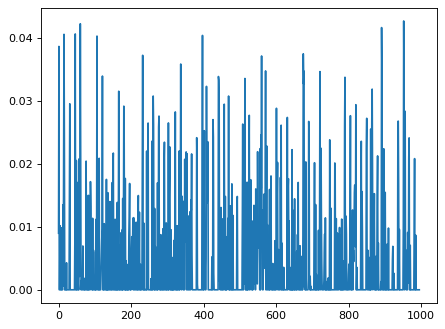

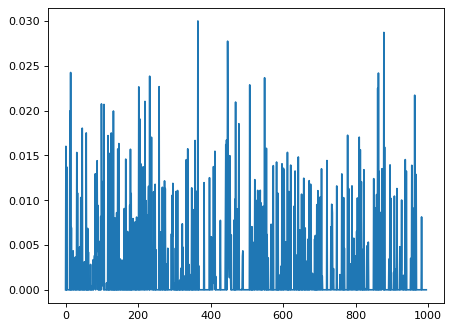

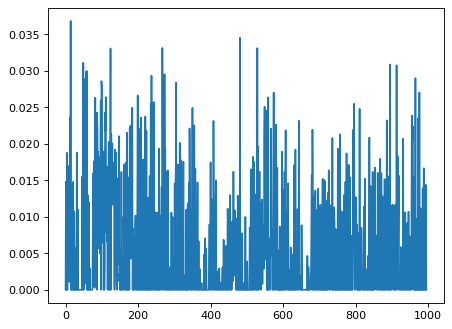

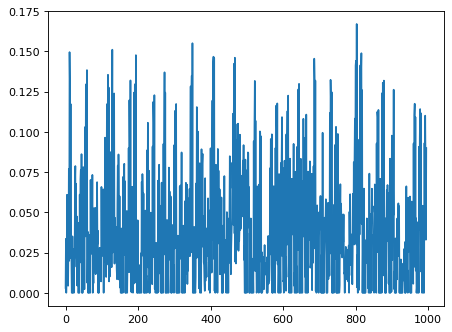

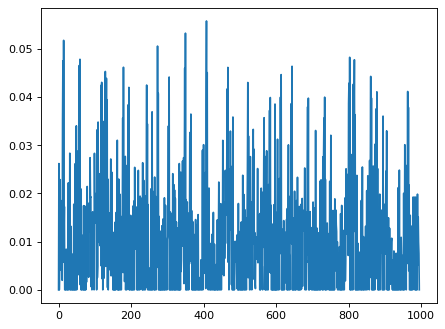

In [15]:
combinationDiffs[combinationDiffs != 0]
newCombDiff = np.copy(combinationDiffs)
newCombDiff[newCombDiff < 0] = 0
onlyOne = newCombDiff[1,:]
from matplotlib import pyplot as plt
# plt.figure()
# plt.plot(onlyOne[:,0]/9)
# plt.figure()
# plt.plot(onlyOne[:,1]/9)
# plt.figure()
# plt.plot(onlyOne[:,2]/9)
# plt.figure()
# plt.plot(onlyOne[:,3]/9)
# plt.figure()
# plt.plot(onlyOne[:,4]/9)
# onlyOne.shape
# onlyOne.shape
# onlyOne
# np.where(onlyOne > np.percentile(onlyOne,99))
# print(onlyOne.shape)
# print(np.percentile(onlyOne,99)/nrOfSeedsPerSubject[1])
# print(np.where(onlyOne[:,1] > np.percentile(onlyOne[:,1],99.5)))
for label in [0,1,2,3,4]:
    plt.figure()
    plt.plot(onlyOne[:,label]/nrOfSeedsPerSubject[1])
    print(f"Label : {label}")
    # for ind in np.where(onlyOne[:,label] > np.percentile(onlyOne[:,label],99.5))[0]:
        
    #     # print(allCombinations[ind])
    #     # print(onlyOne[ind,label]/nrOfSeedsPerSubject[1])
    #     # print((ind+1)//3)
    #     # print((ind+1)/3)


0.24
Using bottom 50 percent instead
0.6
157
332
0.24
Using bottom 50 percent instead
0.65
150
332
0.24
Using bottom 50 percent instead
0.6
152
332
0.24
Using bottom 50 percent instead
0.63
163
332
0.24
Using bottom 50 percent instead
0.78
154
332
(45, 8)
Sad
Angry
Happy
Disgusted
ow


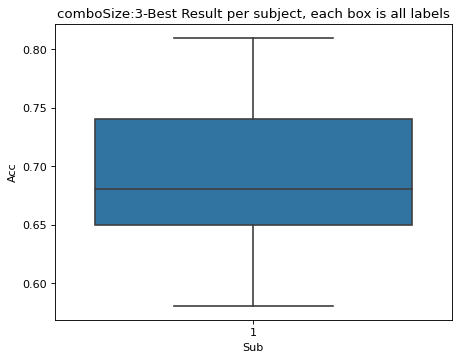

,Acc,Sub,Feat,Kernel,C,Diff,Label,Paradigm
0,0.58,1,normData_GRFirst_&_stftData_GR_CVFirst_&_stftD...,linear,2.5,0.81,Sad,jjjjsahd
9,0.65,1,normData_GRFirst_&_stftData_GR_CVFirst_&_stftD...,linear,2.5,0.81,Angry,jjjjsahd
18,0.68,1,normData_GRFirst_&_stftData_GR_CVFirst_&_stftD...,linear,2.5,0.81,Happy,jjjjsahd
27,0.74,1,normData_GRFirst_&_stftData_GR_CVFirst_&_stftD...,linear,2.5,0.81,Disgusted,jjjjsahd
36,0.81,1,normData_GRFirst_&_stftData_GR_CVFirst_&_stftD...,linear,2.5,0,None,jjjjsahd


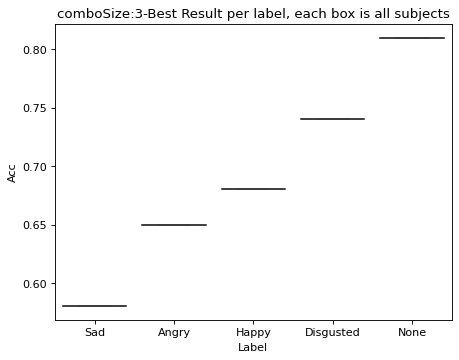

In [16]:
# Not Using HoldOutSet
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=combinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels,
        diffList=onlyOne)
    # table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    # print(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
    plotTop(topPerFeature, featCombos, label, saveTopAvgName=None, perLabel=True)
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Diff", "Label", "Paradigm" ])
#print(labels)
labelAdded = 0
for label in labels[:-1]:
    topDF.loc[topDF['Label'] == f"{label + 1 - labelAdded}", 'Label'] = paradigm[1][1][label-labelAdded][0]
    print(paradigm[1][1][label-labelAdded][0])
    # print(topDF.loc[topDF['Label'] == f"{label+1 - labelAdded}", 'Label'])
topDF.loc[topDF['Label'] == f"{labels[-1] + 1 - labelAdded}", 'Label'] = "None"

import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveTop:
    topDF.to_csv(f"{resultFolder}topFeaturesResults/topPerSubj-para-{paraName}-cmb-{cmbSize}")
if saveAvgTop:
    topDF.to_csv(f"{resultFolder}topFeaturesResultsAvg/topPerSubj-para-{paraName}-cmb-{cmbSize}")
    
if myDataset:
    print("ow")
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
onlyFirst
plt.figure()
sns.boxplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(onlyFirst, y = "Acc", x="Label") # , 
# if "my" in featureSelect:
#     print("ow")
#     onlyFirst = topDF.loc[topDF['Sub'] == "1"]
# else:
#     onlyFirst = topDF

if saveTables:
    onlyFirst.to_csv(f"{resultFolder}tables/topPerSubj-para-{paraName}-cmb-{cmbSize}")
onlyFirst
   

0.24
Using bottom 50 percent instead
0.6
165
332
0.24
Using bottom 50 percent instead
0.61
144
332
0.24
Using bottom 50 percent instead
0.62
155
332
0.24
Using bottom 50 percent instead
0.59
163
332
0.24
Using bottom 50 percent instead
0.78
154
332
(45, 8)
Sad
Angry
Happy
Disgusted


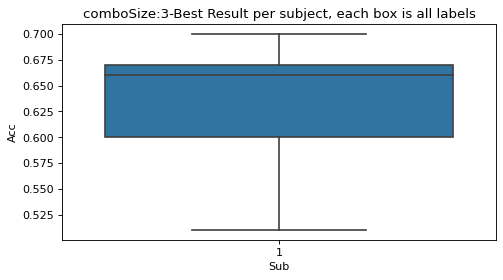

,Acc,Sub,Feat,Kernel,C,Diff,Label,Paradigm
0,0.70,1,normData_GRThird_&_stftData_GR_CVThird_&_stftD...,rbf,2.5,0.67,Sad,jjjjsahd
9,0.66,1,normData_GRThird_&_stftData_GR_CVThird_&_stftD...,rbf,2.5,0.67,Angry,jjjjsahd
18,0.51,1,normData_GRThird_&_stftData_GR_CVThird_&_stftD...,rbf,2.5,0.67,Happy,jjjjsahd
27,0.60,1,normData_GRThird_&_stftData_GR_CVThird_&_stftD...,rbf,2.5,0.67,Disgusted,jjjjsahd
36,0.67,1,normData_GRThird_&_stftData_GR_CVThird_&_stftD...,rbf,2.5,0,None,jjjjsahd


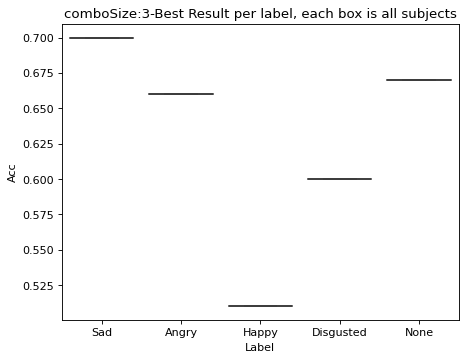

In [17]:
# Using HoldOutSet
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=hcombinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels,
        diffList=onlyOne)
    table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
    plotTop(topPerFeature, featCombos, label, saveTopAvgName=None, perLabel=True)
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Diff", "Label",  "Paradigm" ])
#print(labels)
for label in labels[:-1]:
    topDF.loc[topDF['Label'] == f"{label+1}", 'Label'] = paradigm[1][1][label][0]
    print(paradigm[1][1][label][0])
topDF.loc[topDF['Label'] == f"{labels[-1] + 1 - labelAdded}", 'Label'] = "None"
import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveHoldTop:
    topDF.to_csv(f"{resultFolder}topFeaturesResultsHold/topPerSubj-para-{paraName}-cmb-{cmbSize}")
if myDataset:
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
plt.figure(figsize=[7,3.5])
sns.boxplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(onlyFirst, y = "Acc", x="Label") # , 


if saveTables:
    onlyFirst.to_csv(f"{resultFolder}tables/topPerSubjHold-para-{paraName}-cmb-{cmbSize}")
onlyFirst
   

0.24
Using bottom 50 percent instead
0.11
160
332
[array(['normData_GRThird', 'stftData_GR_CVThird', 'stftData_GR_BCSecond'],
      dtype=object), array(['fftDataSecond', 'stftData_GR_CVFirst', 'stftData_BCSecond'],
      dtype=object)]
ow


<Figure size 560x280 with 0 Axes>

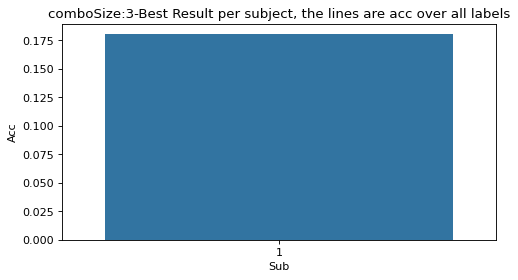

,Acc,Sub,Feat,Kernel,C,Diff,Label,Paradigm
0,0.18,1,normData_GRThird_&_stftData_GR_CVThird_&_stftD...,rbf,2.5,0.67,4,jjjjsahd


In [18]:
# Average accurracy of all labels, using holdout
allResults = []
import matplotlib.pyplot as plt

subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
    combinationResultSep=hcombinationResultSep,
    allCombinations=allCombinations, 
    featCombos=featCombos,
    label=nrOfLabels,
    nrOfCombination=nrOfCombination,
    labels=labels,
    diffList=onlyOne)
table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
newTopTen = []
for feat in topThreeAllSubjects[1:]:
    newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
newTopTen = np.array(newTopTen)
allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
plt.figure(figsize=[7,3.5])
worstCombos = plotTop(topPerFeature, featCombos, label, saveTopAvgName=saveTopAvgName)


testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList.shape)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
# print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Diff", "Label", "Paradigm" ])
import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if myDataset:
    print("ow")
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
plt.figure(figsize=[7,3.5])
sns.barplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, the lines are acc over all labels")
plt.show()
# plt.title(f"comboSize:{cmbSize}-Best Result per label,  the lines are acc over all labels")
# sns.barplot(topDF, y = "Acc", x="Feat") # , 
topDF
if saveHoldTop:
    topDF.to_csv(f"{resultFolder}topFeaturesResultsHold/topPerSubjAvg-para-{paraName}-cmb-{cmbSize}")
if saveTables:
    onlyFirst.to_csv(f"{resultFolder}tables/topPerSubjAvgHold-para-{paraName}-cmb-{cmbSize}")
onlyFirst

0.24
Using bottom 50 percent instead
0.14
158
332
[array(['fftData_BC_ifft_GR_CVSecond', 'stftData_GR_CVFirst',
       'stftData_BCSecond'], dtype=object), array(['fftDataFirst', 'stftData_GR_CVFirst', 'stftData_BCSecond'],
      dtype=object)]
ow


<Figure size 560x280 with 0 Axes>

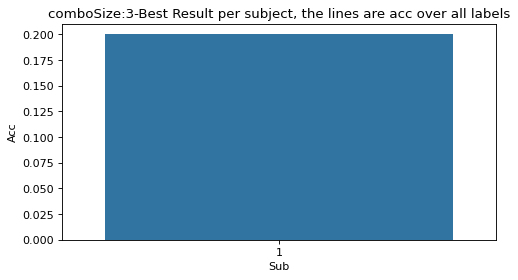

,Acc,Sub,Feat,Kernel,C,Diff,Label,Paradigm
0,0.2,1,normData_GRFirst_&_stftData_GR_CVFirst_&_stftD...,linear,2.5,0.81,4,jjjjsahd


In [19]:
# Average accurracy of all labels, not using holdout
allResults = []
import matplotlib.pyplot as plt

subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
    combinationResultSep=combinationResultSep,
    allCombinations=allCombinations, 
    featCombos=featCombos,
    label=nrOfLabels,
    nrOfCombination=nrOfCombination,
    labels=labels,
    diffList=onlyOne)
table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
newTopTen = []
for feat in topThreeAllSubjects[1:]:
    newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
newTopTen = np.array(newTopTen)
allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
plt.figure(figsize=[7,3.5])
worstCombos = plotTop(topPerFeature, featCombos, label, saveTopAvgName=saveTopAvgName)


testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList.shape)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
# print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Diff", "Label", "Paradigm" ])
import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if myDataset:
    print("ow")
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
plt.figure(figsize=[7,3.5])
sns.barplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, the lines are acc over all labels")
plt.show()
# plt.title(f"comboSize:{cmbSize}-Best Result per label,  the lines are acc over all labels")
# sns.barplot(topDF, y = "Acc", x="Feat") # , 
topDF.to_csv(f"{resultFolder}topFeaturesResults/topPerSubjAvg-para-{paraName}-cmb-{cmbSize}")
onlyFirst
if saveTables:
    onlyFirst.to_csv(f"{resultFolder}tables/topPerSubjAvg-para-{paraName}-cmb-{cmbSize}")
onlyFirst

In [20]:
if worstCombos is not None:
    print(list(worstCombos.keys()))
    print(len(list(worstCombos.keys())))
    if cmbSize == 1:
        np.save(f"{resultFolder}worstFeatures/worstFeats{cmbSize}{paraName}", list(worstCombos.keys()))


['gausData2_BCThird_&_stftData_GR_CVFirst_&_stftData_BCSecond', 'normData_GRFirst_&_stftData_GR_CVFirst_&_stftDataSecond', 'gausData_BC_CVThird_&_stftData_GR_CVThird_&_stftData_GR_BCSecond', 'gausData2_BCThird_&_stftData_GR_CVFirst_&_stftData_GRSecond', 'fftDataFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond', 'gausData2_BCThird_&_stftData_GR_CVFirst_&_stftDataSecond', 'stftData_GR_CVFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird', 'stftData_BCFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird', 'normData_GR_BC_CVFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond', 'gausData_CVFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond', 'gausData_BC_CVFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond', 'fftData_CV_BCThird_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird', 'normData_GRThird_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird', 'fftData_CV_BCFirst_&_stftData_GR_CVFirst_&_stftDataSecond', 'normData_GR_CV_BCFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond', 'fftData_CVThird_&_fftDat

In [21]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


,fftDataFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,fftDataFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,fftDataFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,fftDataFirst_&_stftData_GR_CVFirst_&_stftDataSecond,fftDataFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,fftData_CVFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,fftData_CVFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,fftData_CVFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,fftData_CVFirst_&_stftData_GR_CVFirst_&_stftDataSecond,fftData_CVFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,hilbertData_CVFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,hilbertData_CVFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,hilbertData_CVFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,hilbertData_CVFirst_&_stftData_GR_CVFirst_&_stftDataSecond,hilbertData_CVFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,fftData_BCFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,fftData_BCFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,fftData_BCFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,fftData_BCFirst_&_stftData_GR_CVFirst_&_stftDataSecond,fftData_BCFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,fftData_BC_CVFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,fftData_BC_CVFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,fftData_BC_CVFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,fftData_BC_CVFirst_&_stftData_GR_CVFirst_&_stftDataSecond,fftData_BC_CVFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,gausData_CVFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,gausData_CVFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,gausData_CVFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,gausData_CVFirst_&_stftData_GR_CVFirst_&_stftDataSecond,gausData_CVFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,gausData_BC_CVFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,gausData_BC_CVFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,gausData_BC_CVFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,gausData_BC_CVFirst_&_stftData_GR_CVFirst_&_stftDataSecond,gausData_BC_CVFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,stftDataFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,stftDataFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,stftDataFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,stftDataFirst_&_stftData_GR_CVFirst_&_stftDataSecond,stftDataFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,stftData_BCFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,stftData_BCFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,stftData_BCFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,stftData_BCFirst_&_stftData_GR_CVFirst_&_stftDataSecond,stftData_BCFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,stftData_CVFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,stftData_CVFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,stftData_CVFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,stftData_CVFirst_&_stftData_GR_CVFirst_&_stftDataSecond,stftData_CVFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,fftData_CV_BCFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,fftData_CV_BCFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,fftData_CV_BCFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,fftData_CV_BCFirst_&_stftData_GR_CVFirst_&_stftDataSecond,fftData_CV_BCFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,stftData_GRFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,stftData_GRFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,stftData_GRFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,stftData_GRFirst_&_stftData_GR_CVFirst_&_stftDataSecond,stftData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,stftData_GR_BCFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,stftData_GR_BCFirst_&_stftData_GR_CVThird_&_stftData_GR_BCSecond,stftData_GR_BCFirst_&_stftData_GR_CVFirst_&_stftData_GRSecond,stftData_GR_BCFirst_&_stftData_GR_CVFirst_&_stftDataSecond,stftData_GR_BCFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond,stftData_GR_CVFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird,stftData_GR_

In [22]:
print("Top ten highest accuracies")

# topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.2 : subject 1, feature:fftDataFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernelsigmoid, C:2.5
Accuracy 0.2 : subject 1, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5
Accuracy 0.2 : subject 1, feature:fftData_BCSecond_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5
Accuracy 0.2 : subject 1, feature:fftData_BC_ifft_GRSecond_&_stftData_GR_CVThird_&_stftData_GR_BCSecond, kernelrbf, C:2.5
Accuracy 0.2 : subject 1, feature:fftData_BC_ifft_GR_CVSecond_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5
Accuracy 0.2 : subject 2, feature:fftDataFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernelsigmoid, C:2.5
Accuracy 0.2 : subject 2, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5
Accuracy 0.2 : subject 2, feature:fftData_BCSecond_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5
Accuracy 0.2 : subject 2, feature:fftData_BC_iff

In [23]:
# print("Top ten highest accuracies")
# for subTop in topThreeAllSubjects:
#     subTop.reverse()

In [24]:
# Top results, ordered by subject
arrayOfTopFeatureNames = []

for subTop in topThreeAllSubjects[1:]:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
for subTop in topThreeAllSubjects[1:]:
    print("")
    for top in subTop[1:]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

# np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
np.save(f"{resultFolder}topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"{resultFolder}topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)


Accuracy 0.2 : subject 1, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 2, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 3, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 4, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 5, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 6, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 7, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 8, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 9, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stft

In [25]:
topThreeAllSubjects.sort(reverse=True,  key= lambda i: i[0])

In [26]:
# Top results, ordered by best result

# topThreeAllSubjects.sort()

arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[:-1]:
    print("")
    for top in subTop[:-1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
# print(newArrayOfTopFeatureNames)
# newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
# if saveTopName is not None:
#     np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
#     print("TopFeatureNameArraySaved")
#     print(newArrayOfTopFeatureNames)


Accuracy 0.2 : subject 9, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 8, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 7, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 6, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 5, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 4, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 3, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 2, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond, kernellinear, C:2.5

Accuracy 0.2 : subject 1, feature:normData_GRFirst_&_stftData_GR_CVFirst_&_stft

In [27]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.        0.0939759 0.0939759 0.0939759 0.0939759 0.0939759 0.0939759
 0.0939759 0.0939759 0.0939759]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995
0,0.36,1.35,0.36,0.45,1.26,0.63,1.17,0.81,0.99,1.08,0.63,1.35,1.44,0.9,1.8,0.27,1.08,0.18,0.36,1.08,0.09,0.45,0.81,0.45,0.9,0

Max average accuracy 1.7999999999999998


In [28]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
arrayOfTopFeatureNames2 = []
for maxInd,res in zip(top5[:2], top5Vals[:2]):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    arrayOfTopFeatureNames2.append(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()
    
#     # Top results, ordered by subject

# # for subTop in topThreeAllSubjects[1:]:
# #     print("")
# #     for top in subTop[:-1]:
# #         arrayOfTopFeatureNames.append(top[2])
# #         print(
# #                 f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
# #             )
# arrayOfTopFeatureNames2
# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# arrayOfTopFeatureNames2 = np.array(arrayOfTopFeatureNames2, dtype=object)
# newArrayOfTopFeatureNames2 = []
# for topNames in arrayOfTopFeatureNames2:
#     splitArray = []
#     if "_&_" in topNames:
#         splitArray = np.array(topNames.split("_&_"), dtype=object)
#     else: 
#         splitArray = [topNames]

#     skip = False  
#     if len(splitArray) < cmbSize:
#         continue
#     newArrayOfTopFeatureNames2.append(splitArray)
    
# print(newArrayOfTopFeatureNames2)
# newArrayOfTopFeatureNames2 = np.array(newArrayOfTopFeatureNames2, dtype=object) 
# if saveTopAvgName is not None:
#     np.save(f"topFeatures/{saveTopAvgName}", newArrayOfTopFeatureNames2)
#     print("TopFeatureNameArraySaved")
#     print(newArrayOfTopFeatureNames2)

Based on combAverage
fftData_BC_ifft_GR_CVSecond_&_stftData_GR_CVFirst_&_stftData_BCSecond
linear
1.7999999999999998

fftData_BCSecond_&_stftData_GR_CVFirst_&_stftData_BCSecond
linear
1.7999999999999998



In [29]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
fftData_BC_ifft_GR_CVSecond_&_stftData_GR_CVFirst_&_stftData_BCSecond
linear
0.19999999999999998

fftData_BCSecond_&_stftData_GR_CVFirst_&_stftData_BCSecond
linear
0.19999999999999998

fftData_BC_ifft_GRSecond_&_stftData_GR_CVThird_&_stftData_GR_BCSecond
rbf
0.19999999999999998

normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond
linear
0.19999999999999998

fftDataFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond
sigmoid
0.19999999999999998



In [30]:
def getRes2(combinationResult, combinationResultSep, allCombinations, featCombos, label, nrOfCombination, labels): 
    headers = np.arange(nrOfCombination)
    subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
    subjectNrList = []  
    comboAverage = np.zeros([1, nrOfCombination])
    comboTotal = np.zeros([1, nrOfCombination])
    nrOfSubjects = np.zeros(nrOfCombination)
    combResLabel = labels[-1]
    topTen = []
    topCombResTen = []
    topThreeAllSubjects = []
    topCombResThreeAllSubjects = []
    topPerFeature = np.zeros([10, len(featCombos)])
    topCombResPerFeature = np.zeros([10, len(featCombos)])
    allCombinations = np.array(allCombinations)
    lowestTopRes = [0, 0]
    for subNr, (cResult, sepResult) in enumerate(zip(combinationResult, combinationResultSep)):
        topThreeThisSubject = []
        topCombResThreeThisSubject = []
        resArray = np.zeros([nrOfCombination])
        if len(cResult) != 0:
            for res, sres in zip(cResult,sepResult):
                cmbNr = int(res[0])
                if onlySignificant == True:
                    if res[1] < minAcc:
                        continue
                res[1] = sres[label+1]
                combRes = sres[combResLabel]
                comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
                comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
                nrOfSubjects[cmbNr] += 1
                subjectResultArray[subNr, cmbNr] = res[1]
                comboName = allCombinations[cmbNr][0]
                nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
                if res[1] > topPerFeature[subNr, nameIndex]:
                    topPerFeature[subNr, nameIndex] = res[1]
                    topCombResPerFeature[subNr, nameIndex] = combRes
                    
                if len(topTen) < 10 or topTen[0][0] < res[1]:

                    if len(topTen) == 10:
                        topTen.reverse()
                        topTen.pop()
                    if len(topCombResTen) == 10:
                        topTen.reverse()
                        topTen.pop()

                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topTen.append([res[1], subNr, dataF, kernel, cVal])
                    topCombResTen.append([combRes, subNr, dataF, kernel, cVal])
                    topTen.sort()
                    topCombResTen.sort()

                
                if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                    if len(topThreeThisSubject) == 2:
                        topThreeThisSubject.reverse()
                        topThreeThisSubject.pop()
                    if len(topCombResThreeThisSubject) == 2:
                        topCombResThreeThisSubject.reverse()
                        topCombResThreeThisSubject.pop()
                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                    topThreeThisSubject.sort( key= lambda i: i[0])
                    topCombResThreeThisSubject.append([combRes, subNr, dataF, kernel, cVal])
                    topCombResThreeThisSubject.sort( key= lambda i: i[0])
                    
        if len(topThreeThisSubject)>0:
            topThreeAllSubjects.append(topThreeThisSubject)
        if len(topCombResThreeThisSubject)>0:
            topCombResThreeAllSubjects.append(topCombResThreeThisSubject)
        
        
        
    # Print the table!
    comboAverage = comboAverage / nrOfSubjects
    pd.set_option("display.max_columns", None)

    # For loop through zip of headers and columns,
    # If column has all values == None, Remove column and header.
    subjectResultArray = np.array(subjectResultArray)
    emptyCols = []
    atleastOneEmpty = False
    for hcol, in zip(headers):
        if all(subjectResultArray[:,hcol] == None):
            atleastOneEmpty = True
            emptyCols.append(hcol)
    if atleastOneEmpty: 
        subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
        headers = np.delete(headers, np.array(emptyCols),0)
        comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
        comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
        nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)
    return subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature


(45, 8)
Sad
Angry
Happy
Disgusted


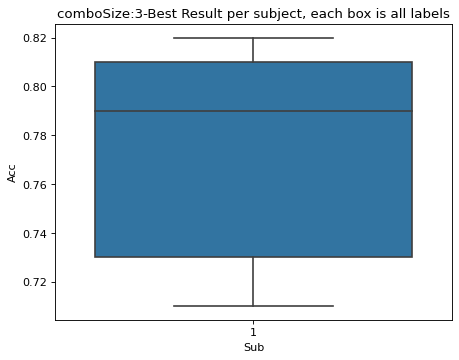

,Acc,Sub,Feat,Kernel,C,Diff,Label,Paradigm
0,0.73,1,normData_GR_BCFirst_&_fftData_BC_CVThird_&_fft...,rbf,2.5,0.87,Sad,jjjjsahd
9,0.79,1,fftDataSecond_&_stftData_GR_CVThird_&_stftData...,rbf,2.5,0.64,Angry,jjjjsahd
18,0.71,1,stftData_GR_BCFirst_&_stftData_GR_CVFirst_&_st...,linear,2.5,0.92,Happy,jjjjsahd
27,0.82,1,normData_GR_BC_CVThird_&_stftData_GR_CVFirst_&...,linear,2.5,0.92,Disgusted,jjjjsahd
36,0.81,1,normData_GRFirst_&_stftData_GR_CVFirst_&_stftD...,linear,2.5,0,None,jjjjsahd


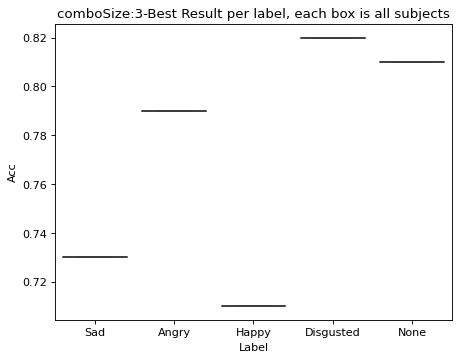

In [31]:
# Not holdout The results below are taken for best feature and hyperparameters per each feature! Highest classification per feature. 
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=combinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels,
        bestSeparate=True,
        diffList=onlyOne)
    table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
    # plotTop(topPerFeature, featCombos, label)
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Diff", "Label", "Paradigm" ])
import seaborn as sns
for label in labels[:-1]:
    topDF.loc[topDF['Label'] == f"{label+1}", 'Label'] = paradigm[1][1][label][0]
    print(paradigm[1][1][label][0])
topDF.loc[topDF['Label'] == f"{labels[-1] + 1 - labelAdded}", 'Label'] = "None"
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveTop:
    topDF.to_csv(f"{resultFolder}topFeaturesResults/topPerLabel-para-{paraName}-cmb-{cmbSize}")
if saveAvgTop:
    topDF.to_csv(f"{resultFolder}topFeaturesResultsAvg/topPerLabel-para-{paraName}-cmb-{cmbSize}")
if myDataset:
    
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
plt.figure()
sns.boxplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(onlyFirst, y = "Acc", x="Label") # , 



if saveTables:
    onlyFirst.to_csv(f"{resultFolder}tables/topPerLabel-para-{paraName}-cmb-{cmbSize}")   
onlyFirst

In [32]:
# arrayOfTopFeatureNames = np.array(pd.unique(topDF["Feat"]))
listOfTopFeatNames = []

for sub in [1,2,3,4,5,6,7,8,9]:
    onlySub = topDF[topDF['Sub'] == f"{sub}"]
    arrayOfTopFeatureNames = np.array(pd.unique(onlySub["Feat"]))
    
    if arrayOfTopFeatureNames.shape[0] < nrOfLabels:
        if nrOfLabels == 4:
            if arrayOfTopFeatureNames.shape[0] < 3:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1]])
            else:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[2], arrayOfTopFeatureNames[0]])
        if nrOfLabels == 2:
            arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[0]])
        # print(arrayOfTopFeatureNames)
        arrayOfTopFeatureNames = np.reshape(arrayOfTopFeatureNames, [-1])
        # print(arrayOfTopFeatureNames)
        # listOfTopFeatNames.extend(arrayOfTopFeatureNames[0])
    listOfTopFeatNames.append(arrayOfTopFeatureNames)
listOfTopFeatNames[2].shape
print(listOfTopFeatNames)
listOfTopFeatNames  = np.concatenate(listOfTopFeatNames)
# for top in listOfTopFeatNames:
arrayOfTopFeatureNames = listOfTopFeatNames

# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"{resultFolder}topFeaturesPerLabel/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)
    print(newArrayOfTopFeatureNames.shape)
    

[array(['normData_GR_BCFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird',
       'fftDataSecond_&_stftData_GR_CVThird_&_stftData_GR_BCSecond',
       'stftData_GR_BCFirst_&_stftData_GR_CVFirst_&_stftDataSecond',
       'normData_GR_BC_CVThird_&_stftData_GR_CVFirst_&_stftDataSecond',
       'normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond'],
      dtype=object), array(['normData_GR_BCFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird',
       'fftDataSecond_&_stftData_GR_CVThird_&_stftData_GR_BCSecond',
       'stftData_GR_BCFirst_&_stftData_GR_CVFirst_&_stftDataSecond',
       'normData_GR_BC_CVThird_&_stftData_GR_CVFirst_&_stftDataSecond',
       'normData_GRFirst_&_stftData_GR_CVFirst_&_stftData_BCSecond'],
      dtype=object), array(['normData_GR_BCFirst_&_fftData_BC_CVThird_&_fftData_BC_ifft_CVThird',
       'fftDataSecond_&_stftData_GR_CVThird_&_stftData_GR_BCSecond',
       'stftData_GR_BCFirst_&_stftData_GR_CVFirst_&_stftDataSecond',
       'normData_GR_BC_CVThi

In [33]:
# listOfTopFeatNames = []
# for sub in [1,2,3,4,5,6,7,8,9]:
#     onlySub = topDF[topDF['Sub'] == f"{sub}"]
#     arrayOfTopFeatureNames = np.array(pd.unique(onlySub["Feat"]))
#     listOfTopFeatNames.append(arrayOfTopFeatureNames)
# listOfTopFeatNames[2].shape
# print(listOfTopFeatNames)
# listOfTopFeatNames  = np.concatenate(listOfTopFeatNames)
# # for top in listOfTopFeatNames:
# listOfTopFeatNames
# # topDF
# # arrayOfTopFeatureNames = np.array(pd.unique(test["Feat"]))
# arrayOfTopFeatureNames

In [34]:
# table = pd.DataFrame(np.array(comboTotal), columns=headers)
# display(table)

# maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

# for maxInd2 in np.where(comboTotal == maxVal2)[1]:
#     print(headers[maxInd2])
#     print(nrOfSubjects[maxInd2])
#     print(
#         f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
#     )
#     print(allCombinations[maxInd2][0])
#     print(allCombinations[maxInd2][1])
#     print(f"C: {allCombinations[maxInd2][2]} ")


(45, 8)
Sad
Angry
Happy
Disgusted


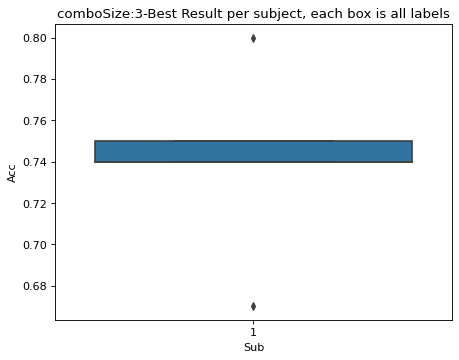

,Acc,Sub,Feat,Kernel,C,Diff,Label,Paradigm
0,0.74,1,stftData_GRThird_&_fftData_BC_CVThird_&_fftDat...,rbf,2.5,0.85,Sad,jjjjsahd
9,0.75,1,normData_GR_BC_CVThird_&_stftData_GR_CVThird_&...,rbf,2.5,0.7,Angry,jjjjsahd
18,0.74,1,fftData_BCFirst_&_stftData_GR_CVFirst_&_stftDa...,rbf,2.5,0.78,Happy,jjjjsahd
27,0.80,1,gausData2_GR_CVFirst_&_stftData_GR_CVFirst_&_s...,linear,2.5,0.84,Disgusted,jjjjsahd
36,0.67,1,normData_GRThird_&_stftData_GR_CVThird_&_stftD...,rbf,2.5,0,None,jjjjsahd


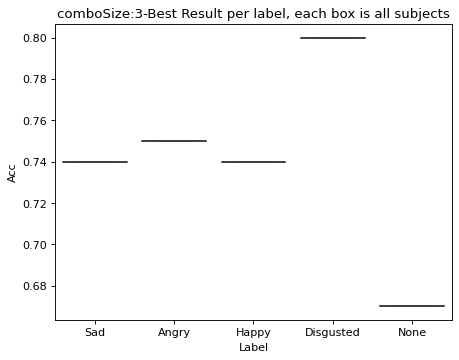

In [35]:
# Using Holdout, The results below are taken for best feature and hyperparameters per each feature! Highest classification per feature. 
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=hcombinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels,
        bestSeparate=True,
        diffList=onlyOne)
    table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
    # plotTop(topPerFeature, featCombos, label)
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Diff", "Label" , "Paradigm" ])
import seaborn as sns
for label in labels[:-1]:
    topDF.loc[topDF['Label'] == f"{label+1}", 'Label'] = paradigm[1][1][label][0]
    print(paradigm[1][1][label][0])
topDF.loc[topDF['Label'] == f"{labels[-1] + 1 - labelAdded}", 'Label'] = "None"
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveHoldTop:
    topDF.to_csv(f"{resultFolder}topFeaturesResultsHold/topPerLabel-para-{paraName}-cmb-{cmbSize}")
# if saveTop:
#     topDF.to_csv(f"topFeaturesResults/topPerLabel-para-{paraName}-cmb-{cmbSize}")
# if saveAvgTop:
#     topDF.to_csv(f"topFeaturesResultsAvg/topPerLabel-para-{paraName}-cmb-{cmbSize}")
if myDataset:
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
plt.figure()
sns.boxplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(onlyFirst, y = "Acc", x="Label") # , 
#topDF["Sub" == 1]


if saveTables:
    onlyFirst.to_csv(f"{resultFolder}tables/topPerLabelHold-para-{paraName}-cmb-{cmbSize}")   
onlyFirst


In [36]:
# arrayOfTopFeatureNames = np.array(pd.unique(topDF["Feat"]))
listOfTopFeatNames = []

for sub in [1,2,3,4,5,6,7,8,9]:
    onlySub = topDF[topDF['Sub'] == f"{sub}"]
    arrayOfTopFeatureNames = np.array(pd.unique(onlySub["Feat"]))
    
    if arrayOfTopFeatureNames.shape[0] < nrOfLabels:
        if nrOfLabels == 4:
            if arrayOfTopFeatureNames.shape[0] < 3:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1]])
            else:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[2], arrayOfTopFeatureNames[0]])
        if nrOfLabels == 2:
            arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[0]])
        # print(arrayOfTopFeatureNames)
        arrayOfTopFeatureNames = np.reshape(arrayOfTopFeatureNames, [-1])
        # print(arrayOfTopFeatureNames)
        # listOfTopFeatNames.extend(arrayOfTopFeatureNames[0])
    listOfTopFeatNames.append(arrayOfTopFeatureNames)
listOfTopFeatNames[2].shape
# print(listOfTopFeatNames)
listOfTopFeatNames  = np.concatenate(listOfTopFeatNames)
# for top in listOfTopFeatNames:
arrayOfTopFeatureNames = listOfTopFeatNames

# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"{resultFolder}topHoldFeaturesPerLabel/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    # print(newArrayOfTopFeatureNames)
    print(newArrayOfTopFeatureNames.shape)
    

[array(['stftData_GRThird', 'fftData_BC_CVThird',
       'fftData_BC_ifft_CVThird'], dtype=object), array(['normData_GR_BC_CVThird', 'stftData_GR_CVThird',
       'stftData_GR_BCSecond'], dtype=object), array(['fftData_BCFirst', 'stftData_GR_CVFirst', 'stftData_GRSecond'],
      dtype=object), array(['gausData2_GR_CVFirst', 'stftData_GR_CVFirst', 'stftDataSecond'],
      dtype=object), array(['normData_GRThird', 'stftData_GR_CVThird', 'stftData_GR_BCSecond'],
      dtype=object), array(['stftData_GRThird', 'fftData_BC_CVThird',
       'fftData_BC_ifft_CVThird'], dtype=object), array(['normData_GR_BC_CVThird', 'stftData_GR_CVThird',
       'stftData_GR_BCSecond'], dtype=object), array(['fftData_BCFirst', 'stftData_GR_CVFirst', 'stftData_GRSecond'],
      dtype=object), array(['gausData2_GR_CVFirst', 'stftData_GR_CVFirst', 'stftDataSecond'],
      dtype=object), array(['normData_GRThird', 'stftData_GR_CVThird', 'stftData_GR_BCSecond'],
      dtype=object), array(['stftData_GRThird', 'fft